In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuración general
plt.style.use('dark_background')
data_dir = "../../data_preprocessed/HOG_SVM"  # ruta relativa desde Programas/HOG_SVM
print("Ruta de datos:", data_dir)


Ruta de datos: ../../data_preprocessed/HOG_SVM


Datasets detectados: ['TACO', 'TrashNet']


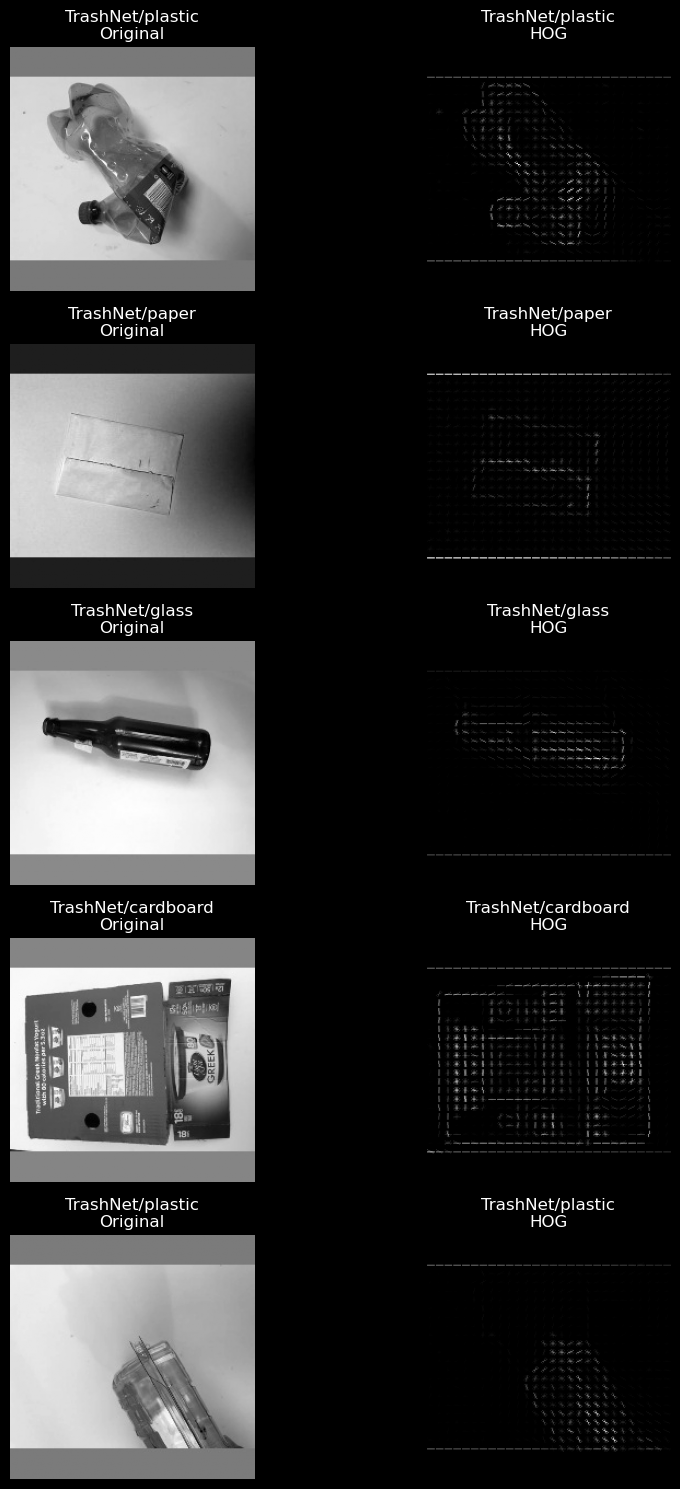

In [7]:
import random

# Mostrar 5 ejemplos aleatorios con su HOG correspondiente
datasets = sorted(os.listdir(data_dir))
print("Datasets detectados:", datasets)

fig, axes = plt.subplots(5, 2, figsize=(10, 15))  # 5 filas, 2 columnas: original y HOG

for i in range(5):
    dataset = random.choice(datasets)
    dataset_path = os.path.join(data_dir, dataset)
    
    # Buscar subclases dentro del dataset
    subclases = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    subclase = random.choice(subclases)
    sub_path = os.path.join(dataset_path, subclase)
    
    # Escoger una imagen aleatoria
    img_name = random.choice(os.listdir(sub_path))
    img_path = os.path.join(sub_path, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # Redimensionar si es pequeña
    if img.shape[0] < 64 or img.shape[1] < 64:
        img = cv2.resize(img, (128, 128))

    # Calcular HOG + visualización
    _, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Mostrar imagen original
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"{dataset}/{subclase}\nOriginal")
    axes[i, 0].axis('off')

    # Mostrar HOG
    axes[i, 1].imshow(hog_image, cmap='gray')
    axes[i, 1].set_title(f"{dataset}/{subclase}\nHOG")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()



In [8]:
import time

X, y = [], []
datasets = sorted(os.listdir(data_dir))
print("Extrayendo características HOG...")

inicio = time.time()

for dataset in datasets:
    dataset_path = os.path.join(data_dir, dataset)
    subclases = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    for subclase in subclases:
        sub_path = os.path.join(dataset_path, subclase)
        for img_name in os.listdir(sub_path):
            img_path = os.path.join(sub_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Redimensionar (para mantener uniformidad)
            img = cv2.resize(img, (128, 128))

            # Calcular características HOG
            features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

            X.append(features)
            y.append(f"{dataset}_{subclase}")

fin = time.time()
print(f"Extracción completada en {fin - inicio:.2f} segundos.")
print(f"Total de muestras: {len(X)}")

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)


Extrayendo características HOG...
Extracción completada en 538.71 segundos.
Total de muestras: 6873


Tamaño del conjunto de entrenamiento: 5498
Tamaño del conjunto de prueba: 1375

Entrenamiento completado en 612.53 segundos.

=== REPORTE DE CLASIFICACIÓN ===
                    precision    recall  f1-score   support

    TACO_cardboard       0.16      0.15      0.16        46
        TACO_glass       0.20      0.18      0.19        49
        TACO_metal       0.31      0.36      0.33       104
        TACO_paper       0.03      0.02      0.02        44
      TACO_plastic       0.54      0.58      0.56       382
        TACO_trash       0.46      0.41      0.43       251
TrashNet_cardboard       0.59      0.69      0.63        80
    TrashNet_glass       0.48      0.52      0.50       100
    TrashNet_metal       0.52      0.42      0.47        81
    TrashNet_paper       0.73      0.73      0.73       115
  TrashNet_plastic       0.51      0.56      0.53        96
    TrashNet_trash       0.91      0.37      0.53        27

          accuracy                           0.49      1375

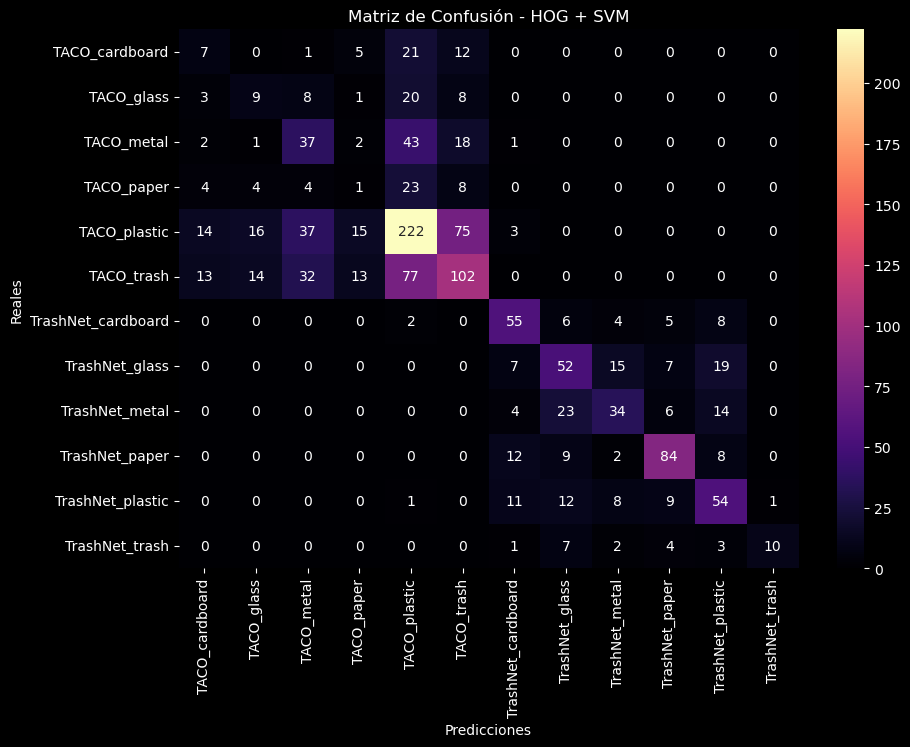

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

# Entrenamiento del modelo SVM
inicio = time.time()
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train, y_train)
fin = time.time()

print(f"\nEntrenamiento completado en {fin - inicio:.2f} segundos.")

# Evaluación del modelo
y_pred = svm_model.predict(X_test)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de Confusión - HOG + SVM")
plt.show()


In [ ]:
import joblib
os.makedirs("modelos_guardados", exist_ok=True)
joblib.dump(svm_model, "modelos_guardados/hog_svm_model.pkl")
print("Modelo guardado como modelos_guardados/hog_svm_model.pkl ✅")
